# Modeling Realised Extractable Value
This notebook demonstrates time-series models that can be used to predict the realised extractable value (REV).

MEV is a theoretical quantity that can only be approached asymptotically. Extractions could happen off-chain or through other hard to trace paths. Hence, we will focus on the Realized Extractable Value (REV) instead, where REV ≤ MEV. In other words, REV is the actual value extracted from the blockchain from MEV opportunities.

REV is approximated by `block_net_profit`, which is calculated as the miner's balance change before and after mining a block, filtered to remove mining pool payout (tx originated from the miner), the static block rewards from PoW and the burnt fee.

The data used in this analysis is obtained post the London fork from block number `12965000` to `15229999`.

## ARIMA
The Autoregressive Integrated Moving Average (ARIMA) model is a time-series model that allows the dependent variable's lag(s), difference(s) and the error terms' lag(s) to be included in a regression as independent variables. This is very useful when time dependencies exist and the intertemporal correlation of the target variable is high.

As shown in the time dependency charts below, although REV is a stationary time-series, it has a positive correlation with its lag term. 

In addition to the endogenous time-dependent factors, exogenous variables can also be included in the ARIMA model. 

In [4]:
####################
## Load Libraries ##
####################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import seaborn as sns
from scipy.special import gamma, factorial
from scipy.stats import beta, gamma, pareto, poisson, nbinom
from scipy import stats
from functools import reduce
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, log_loss, precision_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
import graphviz
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from data_cleansing import rev_data
import warnings
warnings.filterwarnings('ignore')

####################
## Load Functions ##
####################

def format_date(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

def format_date_m(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M')

def format_date_ms(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S.%f')

def format_date_h(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H')

def format_date_d(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d')

def negative_log_likelihood(params, data):
    return -stats.poisson.logpmf(data, params[0]).sum()

def plot_cdf(data, var, lb, ub, increment, title):
    mybins = np.append(-np.inf, np.arange(lb, ub, increment))
    mybins = np.append(mybins, np.inf)
    mybins = np.round(mybins, 2)
    count, bins = np.histogram(data[var], bins=mybins)
    table = pd.DataFrame({'bin': bins[1:], 'count': count})
    table["pdf"] = table["count"] / sum(table["count"])
    table["cdf"] = np.cumsum(table["pdf"])
    
    # plotting CDF
    plt.plot(table['bin'], table["cdf"])
    plt.xlabel(var)
    plt.ylabel('Cumulative percentage')
    plt.title(title)
    
    return table


def aggregate_profit(data, var, profit_name):
    ## Cumulative distribution
    agg = pd.DataFrame(data.groupby(var).size()).reset_index().rename(columns={0:"count"})
    avg_profit = pd.DataFrame(data.groupby(var)[profit_name].mean()).reset_index().rename(columns={profit_name:"avg_profit"})
    med_profit = pd.DataFrame(data.groupby(var)[profit_name].median()).reset_index().rename(columns={profit_name:"median_profit"})
    agg = agg.merge(avg_profit, on = var, how = 'left')
    agg = agg.merge(med_profit, on = var, how = 'left')
    agg['count_perc'] = agg['count']/agg['count'].sum()
    agg['cum_count'] = agg['count'].cumsum()
    agg['cum_count_perc'] = agg['cum_count']/agg['count'].sum()
    agg['cum_avg_profit'] = agg['avg_profit'].cumsum()
    agg['cum_median_profit'] = agg['median_profit'].cumsum()

    return(agg)

def get_confusion_matrix(cm, classes=None, title = 'Confusion Matrix'):
    if classes is not None:
        ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=100., annot=True, cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+0.5, top-0.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
    
    else:
        ax = sns.heatmap(cm, vmin=0., vmax=100., cmap='Blues')
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom+1.5, top-1.5)
        for t in ax.texts: t.set_text(t.get_text()+"%")
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

def plot_confusion_matrix(y, y_hat, class_name, title, fontsize):
    sns.set(font_scale=fontsize)
    cm_train = confusion_matrix(y, y_hat)
    cm_norm_train = cm_train/cm_train.sum(axis=1)[:, np.newaxis]
    plt.figure()
    get_confusion_matrix(cm_norm_train*100, classes=class_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])

def model_performance(y, y_hat):
    print('Balanced Accuracy Score: ', np.round(balanced_accuracy_score(y, y_hat),2))
    print('Log Loss: ', np.round(log_loss(y, y_hat),2))
    out = precision_recall_fscore_support(y, y_hat, average='weighted')
    print('Precision: ', np.round(out[0],2))
    print('Recall: ', np.round(out[1],2))
    print('F-score: ', np.round(out[2],2))

def scatter_plot(x, y, cluster):
    fig, ax = plt.subplots()
    x_name = pd.DataFrame(x).columns.values[0]
    y_name = pd.DataFrame(y).columns.values[0]
    ax.scatter(x,y, c=cluster, label=np.unique(cluster))
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    
def sns_bar_plot(data, xvar, yvar, interval, title):
    plot = sns.barplot(data[xvar], data[yvar])
    for ind, label in enumerate(plot.get_xticklabels()):
        if ind % interval == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    plt.xticks(rotation=90)
    plt.title(title)
    

def equalbins(data, nbin):
    nlen = len(data)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(data))

def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

def mid(s, offset, amount):
    return s[offset:offset+amount]

def aggregate_to_hour(rev_data):
    data_h = pd.DataFrame(rev_data.groupby('datetime_h').size()).reset_index().rename(columns={0:"blocks_count"})
    avg_profit = pd.DataFrame(rev_data.groupby('datetime_h')['block_net_profit'].mean()).reset_index().rename(columns={"block_net_profit":"avg_block_net_profit"})
    med_profit = pd.DataFrame(rev_data.groupby('datetime_h')['block_net_profit'].median()).reset_index().rename(columns={"block_net_profit":"median_block_net_profit"})
    nfb_avg_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_no_bundles'].mean()).reset_index().rename(columns={"profit_no_bundles":"avg_profit_no_bundles"})
    nfb_med_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_no_bundles'].median()).reset_index().rename(columns={"profit_no_bundles":"median_profit_no_bundles"})
    bundle_avg_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_from_bundles'].mean()).reset_index().rename(columns={"profit_from_bundles":"avg_profit_from_bundles"})
    bundle_med_profit = pd.DataFrame(rev_data.groupby('datetime_h')['profit_from_bundles'].median()).reset_index().rename(columns={"profit_from_bundles":"median_profit_from_bundles"})
    gas_avg = pd.DataFrame(rev_data.groupby('datetime_h')['total_gas_used'].mean()).reset_index().rename(columns={"total_gas_used":"avg_total_gas_used"})
    gas_med = pd.DataFrame(rev_data.groupby('datetime_h')['total_gas_used'].median()).reset_index().rename(columns={"total_gas_used":"median_total_gas_used"})
    tail_avg = pd.DataFrame(rev_data.groupby('datetime_h')['tail_gas_price'].mean()).reset_index().rename(columns={"tail_gas_price":"avg_tail_gas_price"})
    tail_med = pd.DataFrame(rev_data.groupby('datetime_h')['tail_gas_price'].median()).reset_index().rename(columns={"tail_gas_price":"median_tail_gas_price"})
    bf_avg = pd.DataFrame(rev_data.groupby('datetime_h')['base_fee_per_gas'].mean()).reset_index().rename(columns={"base_fee_per_gas":"avg_base_fee_per_gas"})
    bf_med = pd.DataFrame(rev_data.groupby('datetime_h')['base_fee_per_gas'].median()).reset_index().rename(columns={"base_fee_per_gas":"median_base_fee_per_gas"})
    eth_avg = pd.DataFrame(rev_data.groupby('datetime_h')['eth_usd_price'].mean()).reset_index().rename(columns={"eth_usd_price":"avg_eth_usd_price"})
    eth_med = pd.DataFrame(rev_data.groupby('datetime_h')['eth_usd_price'].median()).reset_index().rename(columns={"eth_usd_price":"median_eth_usd_price"})
    time_avg = pd.DataFrame(rev_data.groupby('datetime_h')['block_time'].mean()).reset_index().rename(columns={"block_time":"avg_block_time"})
    time_med = pd.DataFrame(rev_data.groupby('datetime_h')['block_time'].median()).reset_index().rename(columns={"block_time":"median_block_time"})
    bundle_count = pd.DataFrame(rev_data.groupby('datetime_h')['bundles_dummy'].sum()).reset_index().rename(columns={"bundles_dummy":"fb_bundles_count"})
    
    data_h = data_h.merge(avg_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(med_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(nfb_avg_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(nfb_med_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bundle_avg_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bundle_med_profit, on = "datetime_h", how = 'left')
    data_h = data_h.merge(gas_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(gas_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(tail_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(tail_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bf_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bf_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(eth_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(eth_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(time_avg, on = "datetime_h", how = 'left')
    data_h = data_h.merge(time_med, on = "datetime_h", how = 'left')
    data_h = data_h.merge(bundle_count, on = "datetime_h", how = 'left')
    
    return data_h

def stationary_test(x):

    out = adfuller(x.dropna())
    print('ADF Statistic: %f' % out[0])
    print('p-value: %f' % out[1])
    if out[1] <= 0.05:
        print('Time-series is stationary at 5% significance level.')
    else:
        print('Time-series is non-stationary at 5% significance level. Find the order of difference!')


def ts_performance(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    smape = 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))
    # me = np.mean(forecast - actual)             # ME
    # mae = np.mean(np.abs(forecast - actual))    # MAE
    # mpe = np.mean((forecast - actual)/actual)   # MPE
    # rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'Mean Absolute Percentage Error':mape, 'Correlation':corr, 'Symmetric Mean Absolute Error':smape})


In [5]:
######################
## Read in REV data ##
######################
rev_data = pd.read_csv('Data/clean_rev.csv')

## Sort data by block number
rev_data = rev_data.sort_values(by=['block_number'], ascending = True)

#################
## Hourly Data ##
#################
rev_data_h = aggregate_to_hour(rev_data)


In [10]:
###########################
## Prepare Modeling Data ##
###########################
## Option 1: Remove outliers
# rev_data_h = rev_data_h[rev_data_h['median_block_net_profit']<=1]

## Option 2: Replace outliers with median value
# rev_data_h['median_block_net_profit'] = np.where(rev_data_h['median_block_net_profit']>1, rev_data_h['median_block_net_profit'].median(), rev_data_h['median_block_net_profit'])

## Option 3: Log-transformation
y = rev_data_h['median_block_net_profit']
x = (rev_data_h[['median_block_time', 'median_eth_usd_price','median_tail_gas_price', 'median_total_gas_used','median_base_fee_per_gas']])

x = np.log(x)
y = np.log(y)

ADF Statistic: -5.176302
p-value: 0.000010
Time-series is stationary at 5% significance level.


(-2.025, 42.525, -0.2, 1.5)

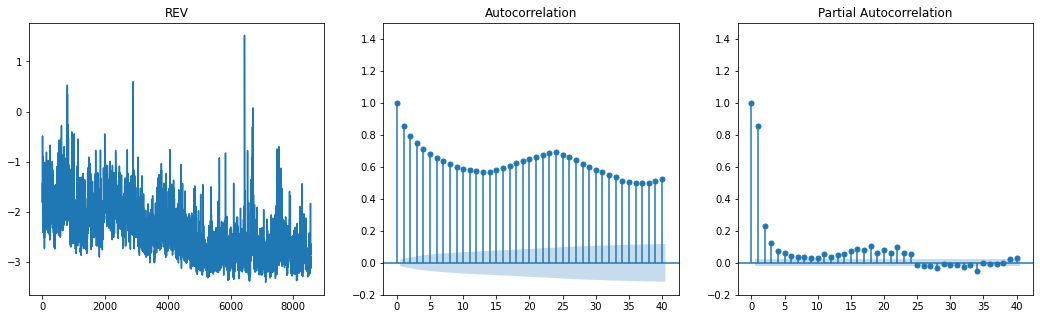

In [11]:
############################
## Time Dependency in REV ##
############################
## perform stationarity test
stationary_test(y) ## stationary

## ACF and PACF plot
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(18,5))
diff0 = y
axes[0].plot(diff0); axes[0].set_title('REV')
plot_acf(diff0.dropna(), ax=axes[1])
axes[1].axis(ymin=-0.2, ymax=1.5)
plot_pacf(diff0.dropna(), ax=axes[2])
axes[2].axis(ymin=-0.2, ymax=1.5)

Text(0, 0.5, 'REV')

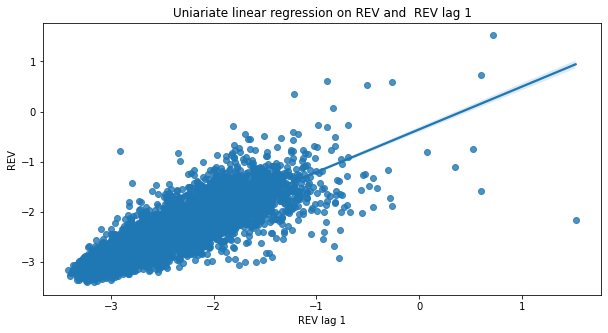

In [12]:
## Univariate analysis regression plot
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=False)
plt.title('Uniariate linear regression on REV and  REV lag 1')
sns.regplot(ax=axes, x=y.shift(-1), y=y)
axes.set_xlabel('REV lag 1')
axes.set_ylabel('REV')


In [13]:
################
## Data Split ##
################
train_size = round(len(rev_data_h)*0.8)
y_train = y[:train_size]
y_test = y[train_size:]
x_train = x[:train_size]
x_test = x[train_size:]

In [14]:
###################
## Initial model ##
###################
## ARIMA(1,0,2) is the best model - original & log-transformed
model = pm.auto_arima(y_train, exogenous=x_train,
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, 
                      # m=1,             
                      d=None,           
                      seasonal=True,   
                      trace=True, 
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=123)

print(model.summary())

pred_train_init, ci_train_init = model.predict(n_periods=len(x_train), exogenous=x_train, return_conf_int=True)
print(ts_performance(pred_train_init, y_train))

pred_test_init, ci_test_init = model.predict(n_periods=len(x_test), exogenous=x_test, return_conf_int=True)
print(ts_performance(pred_test_init, y_test))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2292.993, Time=4.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2274.824, Time=1.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2277.855, Time=4.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=355.930, Time=4.91 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2273.051, Time=2.83 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2397.982, Time=4.76 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2252.985, Time=4.60 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-2215.279, Time=5.74 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2438.939, Time=6.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2530.785, Time=5.57 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-515.537, Time=8.65 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2565.254, Time=6.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-1038.293, Time=5.42 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2552.312, Time=6.92 sec
 ARIMA(1,0,4)(0,0,0)[0] 

{'Mean Absolute Percentage Error': 0.20321656460144655,
 'Correlation': 0.6816863355135238,
 'Symmetric Mean Absolute Error': 0.23445713654166325}

In [15]:
#################
## Final model ##
#################
## ARIMA(1,0,2) - initial model
## Remove insignificant variable - median_block_time; 
## Re-run then remove again insignificant variable - median_eth_usd_price
## final model ** ARIMA(2,0,1) - log-transfomred **
model_final = pm.auto_arima(y_train, exogenous=x_train.drop(['median_block_time','median_eth_usd_price'], axis=1),
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, 
                      # m=1,             
                      d=None,           
                      seasonal=True,   
                      trace=True, 
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=123)

print(model_final.summary())

pred_train, ci_train = model_final.predict(n_periods=len(x_train), exogenous=x_train.drop(['median_block_time','median_eth_usd_price'], axis=1), return_conf_int=True)
print(ts_performance(pred_train, y_train))

pred_test, ci_test = model_final.predict(n_periods=len(x_test), exogenous=x_test.drop(['median_block_time','median_eth_usd_price'], axis=1), return_conf_int=True)
print(ts_performance(pred_test, y_test))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2276.794, Time=3.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2428.501, Time=0.95 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2360.618, Time=3.46 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=114.596, Time=4.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2427.033, Time=2.51 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2233.128, Time=3.80 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2272.060, Time=3.80 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2717.013, Time=2.96 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.79 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3781.565, Time=3.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=144.132, Time=2.59 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4100.551, Time=3.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-3306.870, Time=4.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=4.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             :

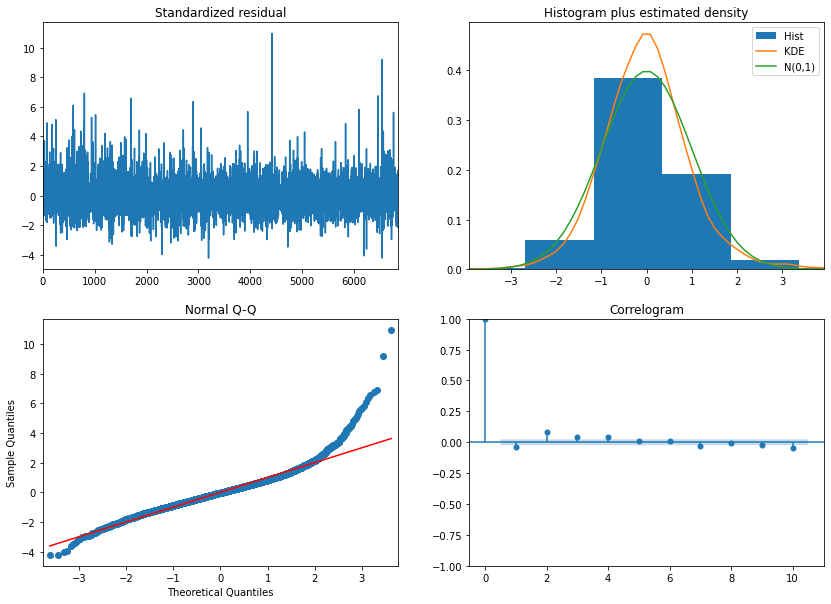

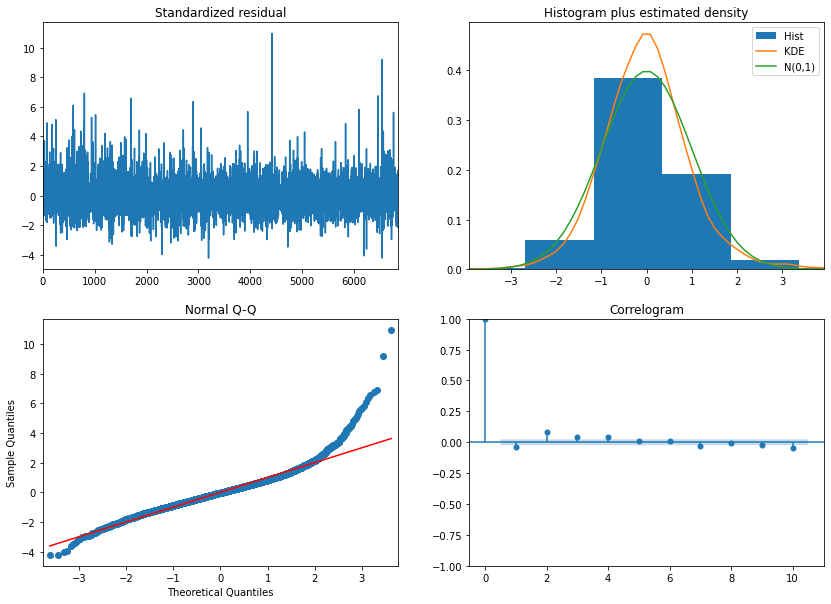

In [10]:
## Check residuals
model_final.plot_diagnostics(figsize=(14,10))

Text(0.5, 1.0, 'ARIMA(2,0,1) Predicted vs. Actual REV (training set)')

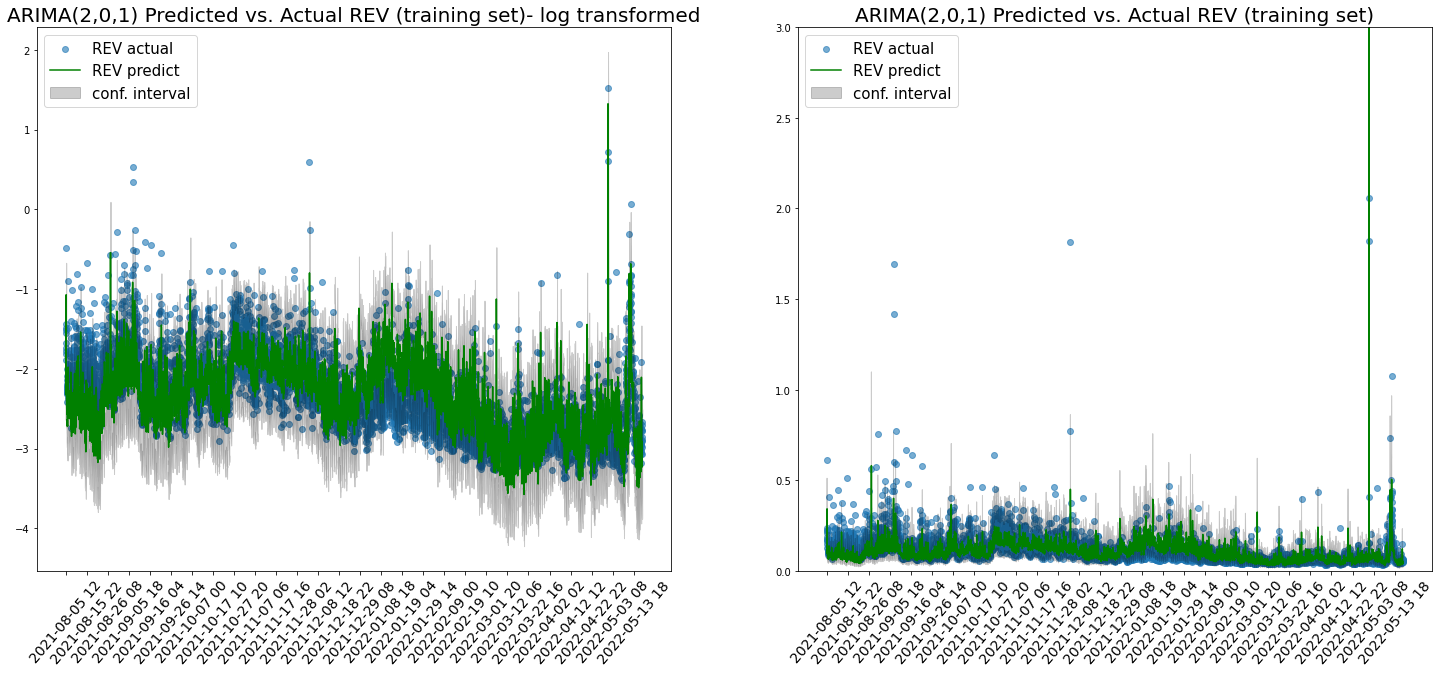

In [17]:
## Plot training set
fitted = pd.Series(pred_train, index=x_train.index)
lb = pd.Series(ci_train[:, 0], index=x_train.index)
ub = pd.Series(ci_train[:, 1], index=x_train.index)

plt.subplots(1, 2, figsize = (25, 10))
## plot log transformed
plt.subplot(1, 2, 1) 
plt.scatter(rev_data_h['datetime_h'][:train_size], y_train, label='REV actual', alpha=0.6)
plt.plot(rev_data_h['datetime_h'][:train_size], fitted, label='REV predict', color='g')
plt.fill_between(lb.index, lb, ub, color='k', alpha=0.2, label='conf. interval')
plt.xticks(np.arange(0, train_size+1, 250))
plt.xticks(rotation = 50, fontsize=14)
plt.legend(fontsize=15, loc='upper left')
plt.title("ARIMA(2,0,1) Predicted vs. Actual REV (training set)- log transformed",fontsize=20)

## plot original
plt.subplot(1, 2, 2) 
plt.scatter(rev_data_h['datetime_h'][:train_size], np.exp(y_train), label='REV actual', alpha=0.6)
plt.plot(rev_data_h['datetime_h'][:train_size], np.exp(fitted), label='REV predict', color='green')
plt.fill_between(lb.index, np.exp(lb), np.exp(ub), color='k', alpha=0.2, label='conf. interval')
plt.xticks(np.arange(0, train_size+1, 250))
plt.xticks(rotation = 50, fontsize=14)
plt.ylim(0,3)
plt.legend(fontsize=15, loc='upper left')
plt.title("ARIMA(2,0,1) Predicted vs. Actual REV (training set)", fontsize=20)


Text(0.5, 1.0, 'ARIMA(2,0,1) Predicted vs. Actual REV')

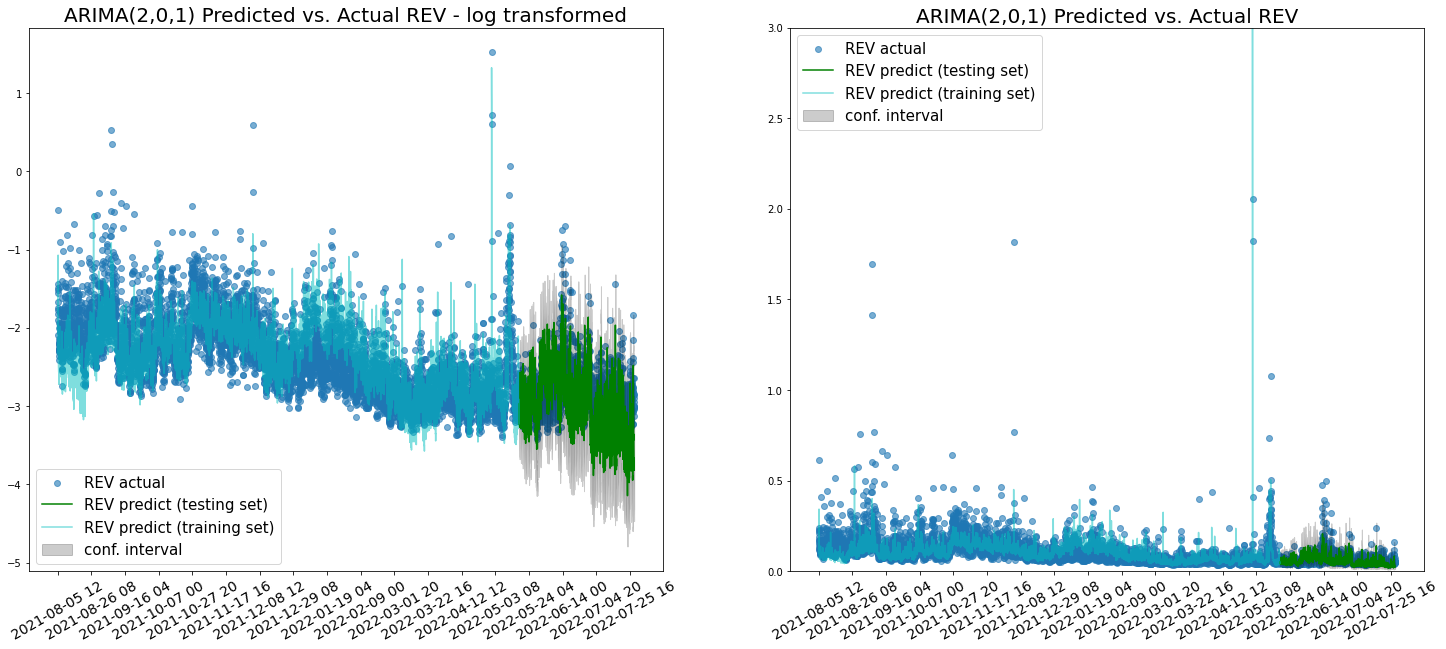

In [22]:
## Plot all set
fitted_train = pd.Series(pred_train, index=x_train.index)
fitted_test = pd.Series(pred_test, index=x_test.index)
lb_test = pd.Series(ci_test[:, 0], index=x_test.index)
ub_test = pd.Series(ci_test[:, 1], index=x_test.index)

plt.subplots(1, 2, figsize = (25, 10))
## plot log transformed
plt.subplot(1, 2, 1) 
plt.scatter(rev_data_h['datetime_h'][:train_size], y_train, label='REV actual', alpha=0.6)
plt.scatter(rev_data_h['datetime_h'][train_size:], y_test, color='#1f77b4', alpha=0.6)
plt.plot(rev_data_h['datetime_h'][train_size:], fitted_test, color='g', label='REV predict (testing set)')
plt.plot(rev_data_h['datetime_h'][:train_size], fitted_train, color='c', label='REV predict (training set)',alpha=0.5)
plt.fill_between(lb_test.index, 
                 lb_test, 
                 ub_test, 
                 color='k', alpha=0.2, label='conf. interval')
plt.xticks(np.arange(0, len(x), 500))
plt.xticks(rotation = 30, fontsize=14)
plt.legend(fontsize=15, loc='lower left')
plt.title("ARIMA(2,0,1) Predicted vs. Actual REV - log transformed", fontsize=20)

## Original data
plt.subplot(1, 2, 2)
plt.scatter(rev_data_h['datetime_h'][:train_size], np.exp(y_train), label='REV actual', alpha=0.6)
plt.scatter(rev_data_h['datetime_h'][train_size:], np.exp(y_test), color='#1f77b4', alpha=0.6)
plt.plot(rev_data_h['datetime_h'][train_size:], np.exp(fitted_test), color='g', label='REV predict (testing set)')
plt.plot(rev_data_h['datetime_h'][:train_size], np.exp(fitted_train), color='c', label='REV predict (training set)',alpha=0.5)
plt.fill_between(lb_test.index, 
                 np.exp(lb_test), 
                 np.exp(ub_test), 
                 color='k', alpha=0.2, label='conf. interval')
plt.xticks(np.arange(0, len(x), 500))
plt.xticks(rotation = 30, fontsize=14)
plt.ylim(0,3)
plt.legend(fontsize=15, loc='upper left')
plt.title("ARIMA(2,0,1) Predicted vs. Actual REV", fontsize=20)


In [27]:
#######################
## Prediction Output ##
#######################
output = rev_data_h[['datetime_h','median_block_net_profit','median_tail_gas_price','median_total_gas_used','median_base_fee_per_gas']]
output['predict'] = np.exp(pd.concat([fitted, fitted_test]))
output['predict_lb'] = np.exp(pd.concat([lb, lb_test])) ## 2.5%
output['predict_ub'] = np.exp(pd.concat([ub, ub_test])) ## 97.5%
output['is_in_ci'] = (output['median_block_net_profit']<=output['predict_ub']) & (output['median_block_net_profit']>=output['predict_lb'])
print("The percentage of predictions inside the conf. intervals is: ", output['is_in_ci'].value_counts(dropna=False)[1]/len(output))

output.to_csv('Data/rev_arima.csv')


The percentage of predictions inside the conf. intervals is:  0.938353765323993


In [24]:
print("The percentage of training set predictions inside the conf. intervals is: ", output['is_in_ci'][:6582].value_counts(dropna=False)[1]/len(output[:6582]))

The percentage of training set predictions inside the conf. intervals is:  0.9472804618656944


In [25]:
print("The percentage of testing set predictions inside the conf. intervals is: ", output['is_in_ci'][6582:].value_counts(dropna=False)[1]/len(output[6582:]))

The percentage of testing set predictions inside the conf. intervals is:  0.9087241553202219
